In [1]:
import numpy as np
import scipy as sp

import matplotlib.pyplot as plt

from qiskit import QuantumCircuit
from qiskit.circuit import Parameter, ParameterVector
from qiskit.circuit.library import EvolvedOperatorAnsatz
from qiskit.quantum_info import SparsePauliOp, Statevector

from qiskit_nature.second_q.operators import FermionicOp
from qiskit_nature.second_q.mappers import JordanWignerMapper
from qiskit_nature.settings import QiskitNatureSettings

QiskitNatureSettings.use_pauli_sum_op = False

## Exercise

We will work with the Hubbard model again this week,
$$H = - t \sum_{i,\sigma} a^\dagger_{i,\sigma} a_{i+1,\sigma} + a^\dagger_{i+1,\sigma} a_{i,\sigma} + U \sum_i n_{i, \uparrow} n_{i, \downarrow} \ .$$

Note that the ordering of qubits is slightly differnt from last week, namely $\bigotimes_i | q_{i,\uparrow} \rangle \bigotimes_i | q_{i,\downarrow} \rangle$ instead of $\bigotimes_i | q_{i,\uparrow} q_{i,\downarrow} \rangle$. For $N=2$ sites, this means $|q_{0, \uparrow} q_{1, \uparrow} q_{0, \downarrow} q_{1, \downarrow}  \rangle$ instead of $|q_{0, \uparrow} q_{0, \downarrow} q_{1, \uparrow} q_{1, \downarrow}  \rangle$

The goal of this exercise is to approximate the ground state of a Hubbard model with VQE.
Specifically, for a Hubbard model at half filling (i.e., half of the sites are occupied with a spin-up electron) with $t = U = 1$ for both $N=2$ and $N=4$ sites.
You are given a method to get the Hubbard Hamiltonian for $N$ sites and, further, a method to prepare the initial state, which contains variational paramerers itself. 

- Implement the cost function that needs to be minimized to variationally approximate the ground state.
- Using this cost function, perform the minimization using `scipy.optimization.minimize`
    - Try out different optimization methods, first `method="COBYLA"`, then with  `method="L-BFGS-B"`
    - Provide an initial guess for the parameter values
    - Pass the necessary additional arguments of the cost function as `args=(...)` to `minimize`.
- Repeat this for $L \in \{ 0, 1, 2, 3, 4 \}$ circuit layers of the ansatz ($L=0$ meaning you only have the initial state, including the initial layer of variational gates to prepare the non-interacting ground state of the Hubbard Hamiltonian)
- For each $L$ and $N$, store the final result of the minimization (VQE), i.e.
    - final value of the cost function (the energy)
    - final parameter values
    - the infidelity with the exact ground state
- **Print and plot** the results as a function of $L$, specifically
    - the relative energy error $|(E_{\rm vqe} - E_{\rm exact}) / E_{\rm exact}|$
    - the infidelity with respect to the exact ground state

In [2]:
def sortES(eigVals, eigVecs):
    """
    simple routine to sort eigenvectors given the eigenvalues
    """

    # Zip the associated eigenvalues and eigenvectors together and sort by eigenvalue
    eigSystem = sorted(zip(eigVals, np.transpose(eigVecs)), key=lambda x: x[0])
    eigValsOut = [eVal for eVal, _ in eigSystem]
    eigVecsOut = [eVec for _, eVec in eigSystem]

    return eigValsOut, eigVecsOut

In [3]:
def get_hubbard_hamiltian(num_sites, t, U):
    """Constructs the Hubbard Hamiltonian in the dict format supported by qiskit-nature.
    Returns a list with two elements, the first being a dict containing the hopping terms,
    the second the onsite terms.
    """
    hopping = {}
    onsite = {}
    for n in range(num_sites - 1):
        hopping[f"+_{n + 1} -_{n}"] = - t
        hopping[f"+_{n} -_{n + 1}"] = - t
        hopping[f"+_{n + 1 + num_sites} -_{n + num_sites}"] = - t
        hopping[f"+_{n + num_sites} -_{n + 1 + num_sites}"] = - t

        onsite[f"+_{n} -_{n} +_{n + num_sites} -_{n + num_sites}"] = U
        onsite[f"+_{n + 1} -_{n + 1} +_{n + 1 + num_sites} -_{n + 1 + num_sites}"] = U

    return [hopping, onsite]

In [4]:
def get_init_circ(num_sites):
    """Constructs the initial state for the variational Hamiltonian ansatz for a Hubbard model at half filling.
    First creates the half-filling state (i.e., half the sites are occupied with a spin-up electron).
    Then appends layers of Givens rotations (see https://www.nature.com/articles/s41467-022-33335-4
    or https://arxiv.org/abs/2302.09824) that variationally prepares the ground state of a non-interacting
    Hubbard model (i.e., no onsite potential, U=0).
    """
    param = Parameter("param")
    Ggate = QuantumCircuit(2, name="G")
    Ggate.h(0)
    Ggate.cx(0, 1)
    Ggate.ry((param / 2), 0)
    Ggate.ry((param / 2), 1)
    Ggate.cx(0, 1)
    Ggate.h(0)

    init_circ = QuantumCircuit(2 * num_sites)
    for i in range(int(num_sites / 2)):
        init_circ.x([i, i + num_sites])

    if num_sites == 2:
        theta = ParameterVector("theta", 1)
        for i in range(num_sites - 1):
            init_circ.append(Ggate.to_instruction({param: theta[0]}), [i, i + 1])
            init_circ.append(
                Ggate.to_instruction({param: theta[0]}),
                [i + num_sites, i + 1 + num_sites],
            )
    else:
        theta = ParameterVector("theta", 3)
        for i in range(1, num_sites - 1, 2):
            init_circ.append(Ggate.to_instruction({param: theta[0]}), [i, i + 1])
            init_circ.append(
                Ggate.to_instruction({param: theta[0]}),
                [i + num_sites, i + 1 + num_sites],
            )
        for i in range(0, num_sites - 1, 2):
            init_circ.append(Ggate.to_instruction({param: theta[1]}), [i, i + 1])
            init_circ.append(
                Ggate.to_instruction({param: theta[1]}),
                [i + num_sites, i + 1 + num_sites],
            )
        for i in range(1, num_sites - 1, 2):
            init_circ.append(Ggate.to_instruction({param: theta[2]}), [i, i + 1])
            init_circ.append(
                Ggate.to_instruction({param: theta[2]}),
                [i + num_sites, i + 1 + num_sites],
            )

    return init_circ

In [5]:
def cost_fun(x, ansatz, operator):
    # At each optimization step, we bind the new parameter values to the ansatz
    # (the parametrized circuit) and compute the energy expectation value
    param_dict = {x_i: x[i] for i, x_i in enumerate(ansatz.parameters)}
    bound = ansatz.bind_parameters(param_dict)
    psi = Statevector(bound).data

    cost = np.real(np.conj(psi).dot(operator).dot(psi))

    return cost

## $N=2$ sites

In [6]:
# Define the system parameters
num_sites = 2
t = 1
U = 1

# we will do VQE for different numbers of layers
num_layers = [0, 1, 2, 3, 4]
vqe_results = {}

# get the dictionary of second quantization operators
hubbard_ops = get_hubbard_hamiltian(num_sites, t, U)

# map the second quantization operators to Pauli operators
num_orbitals = 2 * num_sites
ops_mapped = []
for term in hubbard_ops:
    op = FermionicOp(
        term,
        num_spin_orbitals=num_orbitals,
    )
    print(op)

    ops_mapped.append(JordanWignerMapper().map(op))

# get the Hamiltonian matrix
H = sum(ops_mapped)
H_mat = H.to_matrix()

# get the exact ground state and corresponding energy (for verification)
eigVals, eigVecs = sp.linalg.eig(H)
eigVals, eigVecs = sortES(eigVals, eigVecs)
en_exact = np.real(eigVals[0])
gs_exact = eigVecs[0]

print("\nGround state energy exact")
print(np.real(en_exact))

Fermionic Operator
number spin orbitals=4, number terms=4
  -1 * ( +_1 -_0 )
+ -1 * ( +_0 -_1 )
+ -1 * ( +_3 -_2 )
+ -1 * ( +_2 -_3 )
Fermionic Operator
number spin orbitals=4, number terms=2
  1 * ( +_0 -_0 +_2 -_2 )
+ 1 * ( +_1 -_1 +_3 -_3 )

Ground state energy exact
-1.5615528128088312


In [29]:
# do VQE for different numbers of layers
ansatz_operators = [SparsePauliOp(op.paulis) for op in ops_mapped[::-1]]

en_vqe = []
params_vqe = []
infid_vqe = []

init_circ = get_init_circ(num_sites)
for reps in num_layers:
    print(f"\n *** VQE for {reps} layers", end="  -  ")

    ansatz = EvolvedOperatorAnsatz(
        operators=ansatz_operators,
        reps=reps,
        initial_state=init_circ,
        insert_barriers=True,
    )

    init_vals = np.zeros(ansatz.num_parameters)

    opt_res = sp.optimize.minimize(
        cost_fun, init_vals, args=(ansatz, H_mat), method="L-BFGS-B"
    )
    print(f" results:\n\n{opt_res}")

    psi = ansatz.bind_parameters(
        {x_i: opt_res.x[i] for i, x_i in enumerate(ansatz.parameters)}
    )
    psi = Statevector(psi).data
    overlap = np.conj(psi).dot(gs_exact)
    fidelity = overlap.real**2 + overlap.imag**2

    infid_vqe.append(1 - fidelity)
    en_vqe.append(opt_res.fun)
    params_vqe.append(opt_res.x)

vqe_results[num_sites] = {
    "sites": num_sites,
    "t": t,
    "U": U,
    "en_exact": en_exact,
    "layer": num_layers,
    "energy": en_vqe,
    "infidelity": infid_vqe,
    "parameters": params_vqe,
}


 *** VQE for 0 layers  -   results:

  message: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
  success: True
   status: 0
      fun: -1.4999999999999987
        x: [ 1.571e+00]
      nit: 5
      jac: [ 0.000e+00]
     nfev: 14
     njev: 7
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>

 *** VQE for 1 layers  -   results:

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: -1.500000000213119
        x: [-3.077e-06  7.406e-06  1.571e+00]
      nit: 6
      jac: [ 2.010e-05 -4.921e-05 -1.776e-07]
     nfev: 36
     njev: 9
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>

 *** VQE for 2 layers  -   results:

  message: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
  success: True
   status: 0
      fun: -1.561552812807165
        x: [-7.825e-02  9.768e-02  2.859e-02  5.802e-02  1.571e+00]
      nit: 12
      jac: [-1.554e-07  4.441e-07  3.109e-07  2.442e-07 -2.887e-06]
     nfev: 150
     njev: 25
 hess_inv: <5x5 Lb

In [36]:
delta_E = np.abs(
    (vqe_results[num_sites]["en_exact"] - vqe_results[num_sites]["energy"])
    / vqe_results[num_sites]["en_exact"]
)

print(f"VQE results for N = {num_sites}, t = {t}, U = {U}")
for i in range(len(vqe_results[num_sites]["layer"])):
    print(f"{vqe_results[num_sites]['layer'][i]} layer", end=" - ")
    print(f"energy error {delta_E[i]}", end=" - ")
    print(f"Infidelity: {vqe_results[num_sites]['infidelity'][i]}")

VQE results for N = 2, t = 1, U = 1
0 layer - energy error 0.039417695196690056 - Infidelity: 0.014928749927334728
1 layer - energy error 0.03941769506021026 - Infidelity: 0.014928749875646186
2 layer - energy error 1.0670293708224505e-12 - Infidelity: 6.49147402498329e-13
3 layer - energy error 1.1608779029043824e-12 - Infidelity: 5.392353230604385e-13
4 layer - energy error 6.953323058797685e-14 - Infidelity: 2.886579864025407e-14


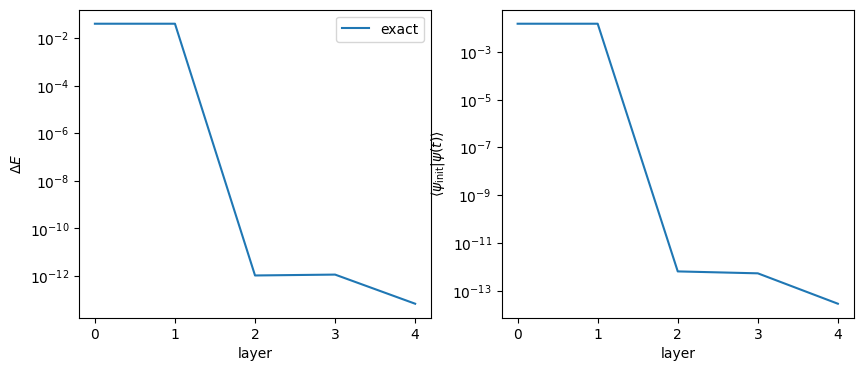

In [38]:
fig, axs = plt.subplots(
    1, 2, figsize=(10, 4), sharex=True, gridspec_kw={"hspace": 0.22}
)
axs[0].plot(vqe_results[num_sites]["layer"], delta_E, label="exact")
axs[0].set_xlabel(rf"layer")
axs[0].set_ylabel(rf"$\Delta E$")
axs[0].set_yscale("log")

axs[1].plot(num_layers, infid_vqe)
axs[1].set_xlabel(rf"layer")
axs[1].set_ylabel(rf"$\langle \psi_{{\rm init}} | \psi(t) \rangle$")
axs[1].set_yscale("log")

axs[0].legend()

plt.show()

## $N=4$ sites

In [7]:
# Define the system parameters
num_sites = 4
U = 1

# get the dictionary of second quantization operators
hubbard_ops = get_hubbard_hamiltian(num_sites, t, U)

# map the second quantization operators to Pauli operators
num_orbitals = 2 * num_sites
ops_mapped = []
for term in hubbard_ops:
    op = FermionicOp(
        term,
        num_spin_orbitals=num_orbitals,
    )
    print(op)

    ops_mapped.append(JordanWignerMapper().map(op))

# get the Hamiltonian matrix
H = sum(ops_mapped)
H_mat = H.to_matrix()

# get the exact ground state and corresponding energy (for verification)
eigVals, eigVecs = sp.linalg.eig(H)
eigVals, eigVecs = sortES(eigVals, eigVecs)
en_exact = np.real(eigVals[0])
gs_exact = eigVecs[0]

print("\nGround state energy exact")
print(np.real(en_exact))

Fermionic Operator
number spin orbitals=8, number terms=12
  -1 * ( +_1 -_0 )
+ -1 * ( +_0 -_1 )
+ -1 * ( +_5 -_4 )
+ -1 * ( +_4 -_5 )
+ -1 * ( +_2 -_1 )
+ -1 * ( +_1 -_2 )
+ -1 * ( +_6 -_5 )
+ -1 * ( +_5 -_6 )
+ -1 * ( +_3 -_2 )
+ -1 * ( +_2 -_3 )
+ -1 * ( +_7 -_6 )
+ -1 * ( +_6 -_7 )
Fermionic Operator
number spin orbitals=8, number terms=4
  1 * ( +_0 -_0 +_4 -_4 )
+ 1 * ( +_1 -_1 +_5 -_5 )
+ 1 * ( +_2 -_2 +_6 -_6 )
+ 1 * ( +_3 -_3 +_7 -_7 )

Ground state energy exact
-3.575365620447488


In [42]:
# do VQE for different numbers of layers
ansatz_operators = [SparsePauliOp(op.paulis) for op in ops_mapped[::-1]]

en_vqe = []
params_vqe = []
infid_vqe = []
for i, reps in enumerate(num_layers):
    print(f"\n *** VQE for {reps} layers", end="  -  ")
    init_circ = get_init_circ(num_sites)

    ansatz = EvolvedOperatorAnsatz(
        operators=ansatz_operators,
        reps=reps,
        initial_state=init_circ,
        insert_barriers=True,
    )

    init_vals = np.zeros(ansatz.num_parameters)

    opt_res = sp.optimize.minimize(
        cost_fun, init_vals, args=(ansatz, H_mat), method="L-BFGS-B"
    )
    print(f" results:\n\n{opt_res}")

    en_vqe.append(opt_res.fun)
    params_vqe.append(opt_res.x)

    psi = ansatz.bind_parameters(
        {x_i: opt_res.x[i] for i, x_i in enumerate(ansatz.parameters)}
    )
    psi = Statevector(psi).data
    overlap = np.conj(psi).dot(gs_exact)
    fidelity = overlap.real**2 + overlap.imag**2
    infid_vqe.append(1 - fidelity)

vqe_results[num_sites] = {
    "sites": num_sites,
    "t": t,
    "U": U,
    "en_exact": en_exact,
    "layer": num_layers,
    "energy": en_vqe,
    "infidelity": infid_vqe,
    "parameters": params_vqe,
}


 *** VQE for 0 layers  -   results:

  message: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
  success: True
   status: 0
      fun: -3.4721359549988104
        x: [ 2.301e+00  1.772e+00  8.411e-01]
      nit: 12
      jac: [-1.110e-06  3.553e-07 -1.332e-06]
     nfev: 64
     njev: 16
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>

 *** VQE for 1 layers  -   results:

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: -3.5493853608726806
        x: [ 5.033e-02 -1.635e-01  2.316e+00  1.764e+00  8.255e-01]
      nit: 18
      jac: [-1.426e-05 -5.818e-06  1.052e-05 -1.865e-05  1.865e-06]
     nfev: 174
     njev: 29
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>

 *** VQE for 2 layers  -   results:

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: -3.5642251655370254
        x: [-3.921e-02  2.847e-01 -7.846e-02  1.472e-01  2.254e+00
             1.799e+00  8.872e-01]
 

In [43]:
delta_E = np.abs(
    (vqe_results[num_sites]["en_exact"] - vqe_results[num_sites]["energy"])
    / vqe_results[num_sites]["en_exact"]
)

print(f"VQE results for N = {num_sites}, t = {t}, U = {U}")
for i in range(len(vqe_results[num_sites]["layer"])):
    print(f"{vqe_results[num_sites]['layer'][i]} layer", end=" - ")
    print(f"energy error {delta_E[i]}", end=" - ")
    print(f"Infidelity: {vqe_results[num_sites]['infidelity'][i]}")

VQE results for N = 4, t = 1, U = 1
0 layer - energy error 0.028872478064427335 - Infidelity: 0.027897953767625827
1 layer - energy error 0.007266462323804491 - Infidelity: 0.008519923374087468
2 layer - energy error 0.003115892496910136 - Infidelity: 0.0037666531955071747
3 layer - energy error 0.00047759489087450434 - Infidelity: 0.0005889215314790475
4 layer - energy error 9.791951643021525e-05 - Infidelity: 9.756911645797395e-05


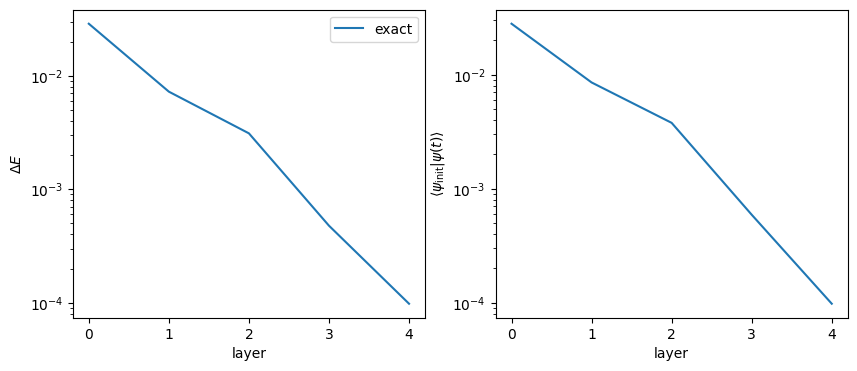

In [44]:
fig, axs = plt.subplots(
    1, 2, figsize=(10, 4), sharex=True, gridspec_kw={"hspace": 0.22}
)
axs[0].plot(vqe_results[num_sites]["layer"], delta_E, label="exact")
axs[0].set_xlabel(rf"layer")
axs[0].set_ylabel(rf"$\Delta E$")
axs[0].set_yscale("log")

axs[1].plot(num_layers, infid_vqe)
axs[1].set_xlabel(rf"layer")
axs[1].set_ylabel(rf"$\langle \psi_{{\rm init}} | \psi(t) \rangle$")
axs[1].set_yscale("log")

axs[0].legend()

plt.show()